In [228]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from __future__ import division
from sklearn.cluster import KMeans

#do not show warnings
import warnings
warnings.filterwarnings("ignore")

# #import plotly for visualization
# import plotly.plotly as py
# import plotly.offline as pyoff
# import plotly.graph_objs as go

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [229]:
VideoStarted = pd.read_csv('../Capstone - 02/02_data/Data/VideoStarted.csv')
VideoStarted['Date'] = pd.to_datetime(VideoStarted['Date'],format='%Y%m%d')

In [230]:
tx_6m = VideoStarted[(VideoStarted['Date'] < date(2017,5,15)) & (VideoStarted['Date'] >= date(2017,1,1))].reset_index(drop=True)
tx_next = VideoStarted[(VideoStarted['Date'] >= date(2017,5,15)) & (VideoStarted['Date'] < date(2017,6,15))].reset_index(drop=True)

In [231]:
(len(tx_6m) + len(tx_next)) == len(VideoStarted)

True

In [232]:
tx_user = pd.DataFrame(tx_6m['UserId'].unique())
tx_user.columns = ['UserId']
print('Users in tx_user DataFrame - ',len(tx_user['UserId'].value_counts()))

Users in tx_user DataFrame -  122041


In [233]:
#create a dataframe with customer id and first purchase date in tx_next
tx_next_first_purchase = tx_next.groupby('UserId')['Date'].min().reset_index()
tx_next_first_purchase.columns = ['UserId','MinPurchaseDate']

#create a dataframe with customer id and last purchase date in tx_6m
tx_last_purchase = tx_6m.groupby('UserId')['Date'].max().reset_index()
tx_last_purchase.columns = ['UserId','MaxPurchaseDate']

#merge two dataframes
tx_purchase_dates = pd.merge(tx_last_purchase,tx_next_first_purchase,on='UserId',how='left')

#calculate the time difference in days:
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days

#merge with tx_user 
tx_user = pd.merge(tx_user, tx_purchase_dates[['UserId','NextPurchaseDay']],left_on='UserId',right_on='UserId',how='left')

print('Users in tx_user DataFrame - ',len(tx_user['UserId'].value_counts()))

Users in tx_user DataFrame -  122041


In [234]:

tx_user.head(10)

,UserId,NextPurchaseDay
0,0280dfdd112732a3ac12b12dc770b7af,NaN
1,435d41ae019cb8db785483793859c9a8,NaN
2,1faf0ce0b98e02e1568702f516f01a78,NaN
3,3ec691b9d2b5d53ef965fe59b1900b30,NaN
4,ff230d487a7139b65f33b54a4cbd2d9e,NaN
5,13d9f55e297d7d9c219fbe9085e1006c,NaN
6,ca601ff304bf0c0836f8a59f7751b8de,NaN
7,f717dc3f757dc18cc0c3f27ed3e94ef8,6.0
8,0d2717ba754737c78430788ed77a1db7,NaN
9,087c741c167a352d07822fcab58046e5,NaN


In [235]:
#get max purchase date for Recency and create a dataframe
tx_max_purchase = tx_6m.groupby('UserId')['Date'].max().reset_index()
tx_max_purchase.columns = ['UserId','MaxPurchaseDate']

#find the recency in days and add it to tx_user
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['UserId','Recency']], on='UserId')

print('Users in tx_user DataFrame - ',len(tx_user['UserId'].value_counts()))

tx_user.head()

Users in tx_user DataFrame -  122041


,UserId,NextPurchaseDay,Recency
0,0280dfdd112732a3ac12b12dc770b7af,NaN,128
1,435d41ae019cb8db785483793859c9a8,NaN,128
2,1faf0ce0b98e02e1568702f516f01a78,NaN,118
3,3ec691b9d2b5d53ef965fe59b1900b30,NaN,128
4,ff230d487a7139b65f33b54a4cbd2d9e,NaN,113


In [236]:
#clustering for Recency
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [237]:
#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [238]:
#order recency clusters
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)
print('Users in tx_user DataFrame - ',len(tx_user['UserId'].value_counts()))

Users in tx_user DataFrame -  122041


In [239]:
#print cluster characteristics
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,26828.0,109.189243,11.027166,90.0,100.0,110.0,119.0,128.0
1,19004.0,70.685172,10.393513,54.0,62.0,70.0,80.0,89.0
2,27889.0,36.641149,8.430912,24.0,29.0,35.0,44.0,53.0
3,48320.0,9.742281,7.180414,0.0,3.0,9.0,16.0,23.0


In [240]:
#get total purchases for frequency scores
tx_frequency = tx_6m.groupby('UserId')['Date'].count().reset_index()
tx_frequency.columns = ['UserId','Frequency']


In [241]:
#add frequency column to tx_user
tx_user = pd.merge(tx_user, tx_frequency, on='UserId')
print('Users in tx_user DataFrame - ',len(tx_user['UserId'].value_counts()))
tx_user.head()

Users in tx_user DataFrame -  122041


,UserId,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,0280dfdd112732a3ac12b12dc770b7af,NaN,128,0,1
1,435d41ae019cb8db785483793859c9a8,NaN,128,0,1
2,1faf0ce0b98e02e1568702f516f01a78,NaN,118,0,13
3,3ec691b9d2b5d53ef965fe59b1900b30,NaN,128,0,1
4,ff230d487a7139b65f33b54a4cbd2d9e,NaN,113,0,5


In [242]:
#clustering for frequency
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [243]:
#order frequency clusters and show the characteristics
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)
print('Users in tx_user DataFrame - ',len(tx_user['UserId'].value_counts()))
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

Users in tx_user DataFrame -  122041


,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,108814.0,4.396355,4.155770,1.0,1.00,3.0,6.00,19.0
1,11786.0,34.702698,13.637125,20.0,24.00,30.0,42.00,76.0
2,1329.0,117.982694,41.424963,77.0,87.00,104.0,134.00,268.0
3,112.0,418.866071,166.577553,271.0,309.25,360.0,458.25,1044.0


In [244]:
#building overall segmentation
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster']

In [245]:
#assign segment names
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

print('Users in tx_user DataFrame - ',len(tx_user['UserId'].value_counts()))

Users in tx_user DataFrame -  122041


In [246]:
tx_user[tx_user['Segment']=='High-Value'].head()

,UserId,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,OverallScore,Segment
120682,dc93d200565e5bf6e6fc55adb1c5ba06,11.0,10,3,199,2,5,High-Value
120683,e67250dc001f274e035196ae67a12fb1,2.0,0,3,109,2,5,High-Value
120684,3323c47255d8a281d07bc0c0577c0d9e,NaN,22,3,129,2,5,High-Value
120685,b23748a0e45729d9c8ccf1e8d4aa22ad,13.0,9,3,85,2,5,High-Value
120686,6caace48aee133cdbb5ce1c40221bb6c,14.0,9,3,82,2,5,High-Value


In [247]:
#create a dataframe with CustomerID and Invoice Date
tx_day_order = tx_6m[['UserId','Date']]

tx_day_order = tx_day_order.sort_values(['UserId','Date'])

In [248]:
#drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['UserId','Date'],keep='first')

In [249]:
#shifting last 3 purchase dates
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('UserId')['Date'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('UserId')['Date'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('UserId')['Date'].shift(3)

In [250]:
tx_day_order.head(10)

,UserId,Date,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
207115,0000146e97c32d369268e5ba5f4b907c,2017-02-23,NaT,NaT,NaT
787101,00004010d92c2f13b824237bc323d58b,2017-04-30,NaT,NaT,NaT
314438,0000e560394fce891dcf80218793d181,2017-03-24,NaT,NaT,NaT
318718,0000e560394fce891dcf80218793d181,2017-03-25,2017-03-24,NaT,NaT
570836,00015c69cccd32bcd323227b7140d8a8,2017-04-19,NaT,NaT,NaT
584523,00015c69cccd32bcd323227b7140d8a8,2017-04-20,2017-04-19,NaT,NaT
702989,00015c69cccd32bcd323227b7140d8a8,2017-04-26,2017-04-20,2017-04-19,NaT
711398,00016f6ad820aa24940343f837799519,2017-04-26,NaT,NaT,NaT
745440,00016f6ad820aa24940343f837799519,2017-04-28,2017-04-26,NaT,NaT
767111,00016f6ad820aa24940343f837799519,2017-04-29,2017-04-28,2017-04-26,NaT


In [251]:
tx_day_order['DayDiff'] = (tx_day_order['Date'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['Date'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['Date'] - tx_day_order['T3InvoiceDate']).dt.days

In [252]:
tx_day_order.head(10)

,UserId,Date,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
207115,0000146e97c32d369268e5ba5f4b907c,2017-02-23,NaT,NaT,NaT,NaN,NaN,NaN
787101,00004010d92c2f13b824237bc323d58b,2017-04-30,NaT,NaT,NaT,NaN,NaN,NaN
314438,0000e560394fce891dcf80218793d181,2017-03-24,NaT,NaT,NaT,NaN,NaN,NaN
318718,0000e560394fce891dcf80218793d181,2017-03-25,2017-03-24,NaT,NaT,1.0,NaN,NaN
570836,00015c69cccd32bcd323227b7140d8a8,2017-04-19,NaT,NaT,NaT,NaN,NaN,NaN
584523,00015c69cccd32bcd323227b7140d8a8,2017-04-20,2017-04-19,NaT,NaT,1.0,NaN,NaN
702989,00015c69cccd32bcd323227b7140d8a8,2017-04-26,2017-04-20,2017-04-19,NaT,6.0,7.0,NaN
711398,00016f6ad820aa24940343f837799519,2017-04-26,NaT,NaT,NaT,NaN,NaN,NaN
745440,00016f6ad820aa24940343f837799519,2017-04-28,2017-04-26,NaT,NaT,2.0,NaN,NaN
767111,00016f6ad820aa24940343f837799519,2017-04-29,2017-04-28,2017-04-26,NaT,1.0,3.0,NaN


In [253]:
tx_day_diff = tx_day_order.groupby('UserId').agg({'DayDiff': ['mean','std']}).reset_index()
tx_day_diff.columns = ['UserId', 'DayDiffMean','DayDiffStd']

In [254]:
tx_day_order_last = tx_day_order.drop_duplicates(subset=['UserId'],keep='last')

In [255]:
tx_day_order_last = tx_day_order_last.dropna()
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='UserId')

In [256]:
tx_user = pd.merge(tx_user, tx_day_order_last[['UserId','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='UserId')
print('Users in tx_user DataFrame - ',len(tx_user['UserId'].value_counts()))

Users in tx_user DataFrame -  19548


In [257]:
tx_user.head()

,UserId,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,1faf0ce0b98e02e1568702f516f01a78,NaN,118,0,13,0,0,Low-Value,1.0,6.0,7.0,1.666667,1.632993
1,087c741c167a352d07822fcab58046e5,NaN,124,0,17,0,0,Low-Value,1.0,2.0,3.0,1.000000,0.000000
2,d474ce5957c78efaa070f8266791060c,NaN,101,0,9,0,0,Low-Value,9.0,14.0,19.0,4.500000,3.082207
3,6f1e17087d0349318105784ce0fb323a,NaN,104,0,17,0,0,Low-Value,7.0,8.0,12.0,4.000000,2.000000
4,e8df3764a62d0cb144f3095f56dcfebd,NaN,121,0,7,0,0,Low-Value,2.0,4.0,5.0,1.750000,0.500000


In [258]:
#create tx_class as a copy of tx_user before applying get_dummies
tx_class = tx_user.copy()
tx_class.set_index('UserId',inplace=True)
tx_class = pd.get_dummies(tx_class)
tx_class.reset_index(inplace=True)
print('Users in tx_user DataFrame - ',len(tx_user['UserId'].value_counts()))

Users in tx_user DataFrame -  19548


In [259]:
tx_class.head()

,UserId,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,1faf0ce0b98e02e1568702f516f01a78,NaN,118,0,13,0,0,1.0,6.0,7.0,1.666667,1.632993,0,1,0
1,087c741c167a352d07822fcab58046e5,NaN,124,0,17,0,0,1.0,2.0,3.0,1.000000,0.000000,0,1,0
2,d474ce5957c78efaa070f8266791060c,NaN,101,0,9,0,0,9.0,14.0,19.0,4.500000,3.082207,0,1,0
3,6f1e17087d0349318105784ce0fb323a,NaN,104,0,17,0,0,7.0,8.0,12.0,4.000000,2.000000,0,1,0
4,e8df3764a62d0cb144f3095f56dcfebd,NaN,121,0,7,0,0,2.0,4.0,5.0,1.750000,0.500000,0,1,0


In [260]:
tx_user['NextPurchaseDay'].describe()

count    6304.000000
mean        9.059486
std        11.951145
min         1.000000
25%         3.000000
50%         6.000000
75%        11.000000
max       140.000000
Name: NextPurchaseDay, dtype: float64

In [261]:
len(tx_user)

19548

In [262]:
len(tx_next['UserId'].value_counts())

56216

In [263]:
len(tx_6m['UserId'].value_counts())

122041

In [264]:
'''5 Class Prediction'''

# tx_class.loc[tx_class.NextPurchaseDay.isnull(),'NextPurchaseDayRange'] = 0
# tx_class.loc[(tx_class.NextPurchaseDay<3) & (tx_class.NextPurchaseDay>=0),'NextPurchaseDayRange'] = 1
# tx_class.loc[(tx_class.NextPurchaseDay<8) & (tx_class.NextPurchaseDay>=3),'NextPurchaseDayRange'] = 2
# tx_class.loc[(tx_class.NextPurchaseDay>16) & (tx_class.NextPurchaseDay>=8),'NextPurchaseDayRange'] = 3
# tx_class.loc[tx_class.NextPurchaseDay>15,'NextPurchaseDayRange'] = 4

'5 Class Prediction'

In [265]:
'''4 Class Predictons '''

tx_class.loc[tx_class.NextPurchaseDay.isnull(),'NextPurchaseDayRange'] = 0
tx_class.loc[(tx_class.NextPurchaseDay<3) & (tx_class.NextPurchaseDay>=0),'NextPurchaseDayRange'] = 1
tx_class.loc[(tx_class.NextPurchaseDay<8) & (tx_class.NextPurchaseDay>=3),'NextPurchaseDayRange'] = 2
tx_class.loc[tx_class.NextPurchaseDay>7,'NextPurchaseDayRange'] = 3

In [266]:
tx_class['NextPurchaseDayRange'].value_counts()

0.0    13244
2.0     2611
3.0     2169
1.0     1524
Name: NextPurchaseDayRange, dtype: int64

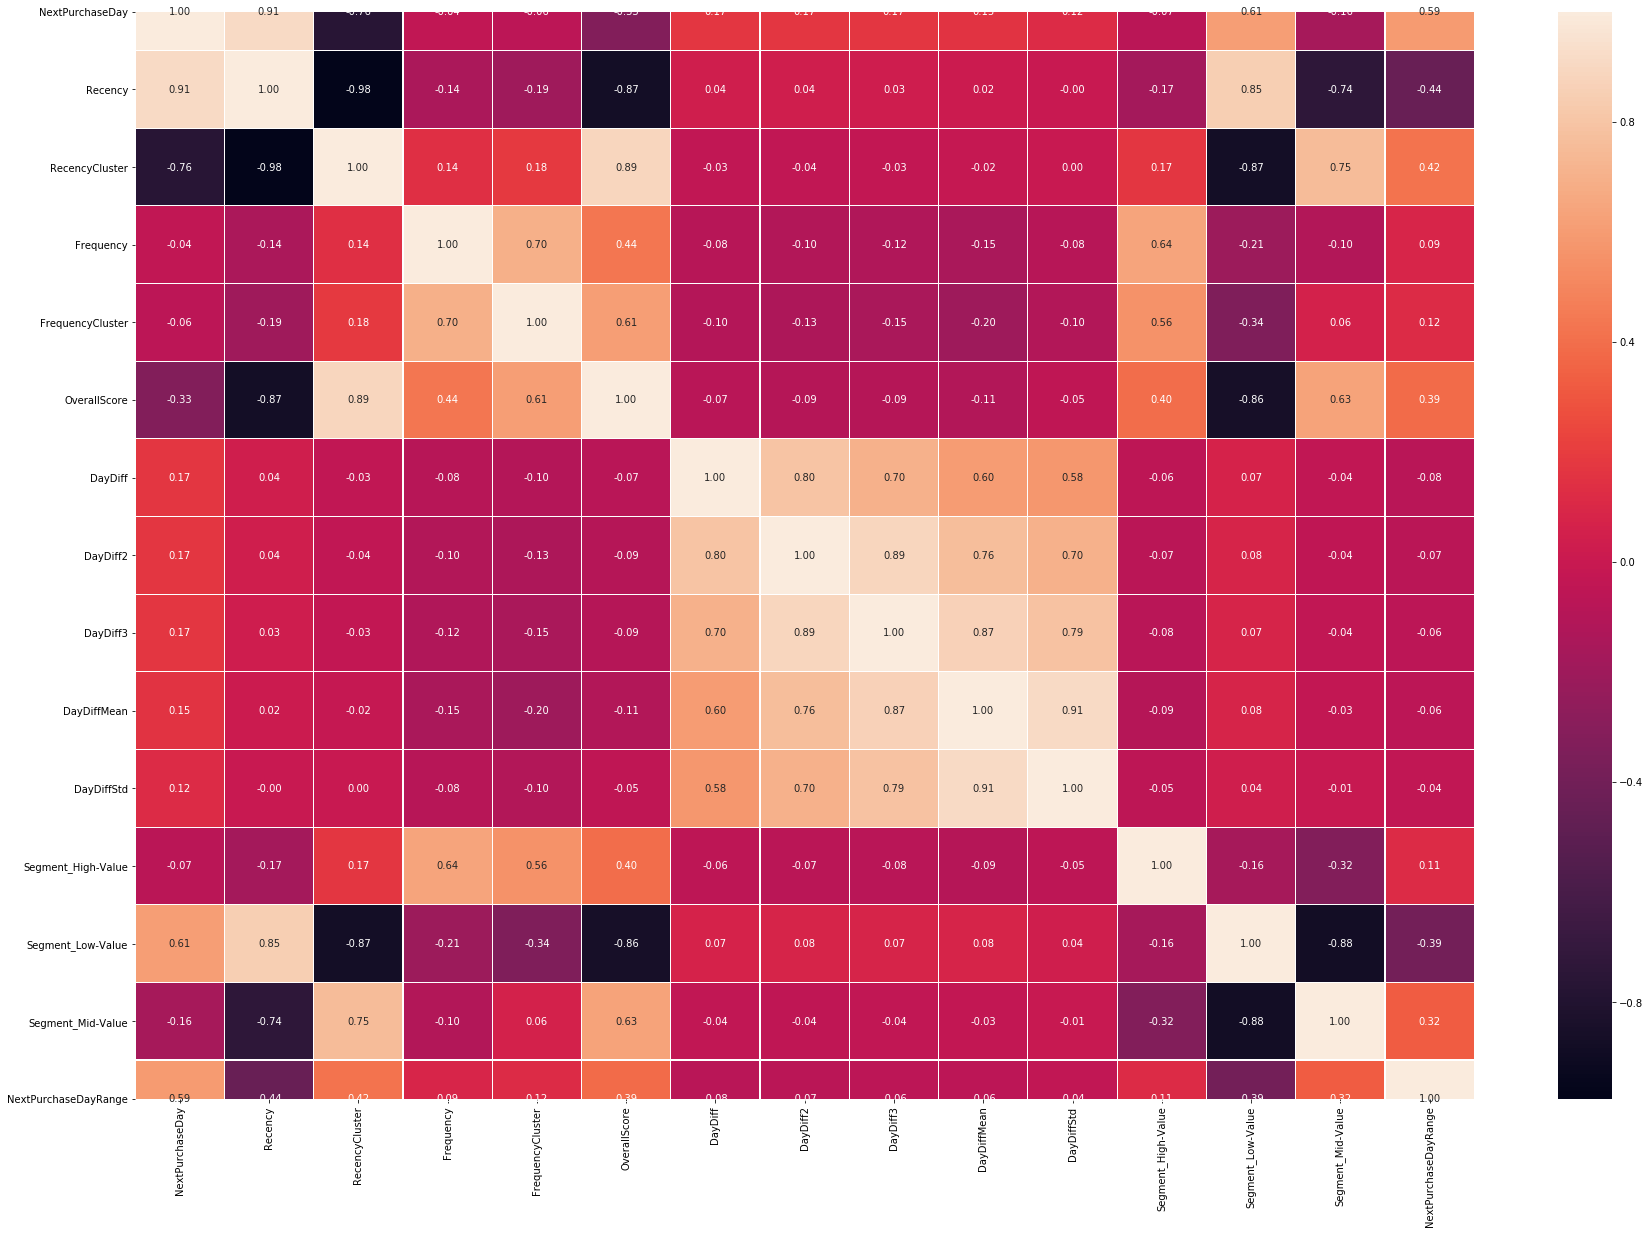

In [267]:
corr = tx_class[tx_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [268]:
#train & test split
tx_class = tx_class.drop(['NextPurchaseDay','UserId'],axis=1)
X, y = tx_class.drop('NextPurchaseDayRange',axis=1), tx_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [269]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
# models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
# models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

In [270]:
#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.75866479 0.75342115]
NB [0.58038112 0.57424223]
RF [0.73832971 0.73359765]
Dtree [0.6986827 0.6965085]
KNN [0.73283029 0.73410922]


In [271]:
LR = LogisticRegression()
kfold = KFold(n_splits=2, random_state=22)
cv_result = cross_val_score(LR,X_train,y_train, cv = kfold,scoring = "accuracy")
print(cv_result)

[0.75866479 0.75342115]


In [272]:
from sklearn import metrics
from sklearn.metrics import f1_score
LR.fit(X_train, y_train)    

cv = np.mean(cross_val_score(LR, X_train, y_train, cv=10))
print ("Accuracy using RF with 10 cross validation : {}%".format(round(cv*100,2)))
y_predict_test = LR.predict(X_test)

#F1_score

score_test = metrics.f1_score(y_test, y_predict_test, 
                              pos_label=list(set(y_test)), average = None)


Accuracy using RF with 10 cross validation : 75.66%


In [273]:
score_test

array([0.87576021, 0.60179641, 0.44328824, 0.        ])

In [274]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 

In [275]:
LR.fit(X_train_res, y_train_res)    

cv = np.mean(cross_val_score(LR, X_train_res, y_train_res, cv=10))
print ("Accuracy using RF with 10 cross validation : {}%".format(round(cv*100,2)))
y_predict_test = LR.predict(X_test)

#F1_score

score_test = metrics.f1_score(y_test, y_predict_test, 
                              pos_label=list(set(y_test)), average = None)


Accuracy using RF with 10 cross validation : 69.29%


In [276]:
print(classification_report(y_test, y_predict_test)) 

              precision    recall  f1-score   support

         0.0       0.97      0.62      0.76      2694
         1.0       0.48      0.77      0.59       273
         2.0       0.42      0.58      0.49       509
         3.0       0.22      0.53      0.31       434

    accuracy                           0.62      3910
   macro avg       0.52      0.62      0.54      3910
weighted avg       0.78      0.62      0.66      3910

